Import All Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report

Load Dataset

In [2]:
df = pd.read_csv("titanic.csv")

Exploratory Data Analysis

In [3]:
print("Summary Statistics:")
print(df.describe())

Summary Statistics:
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


Distribution of Target Variable

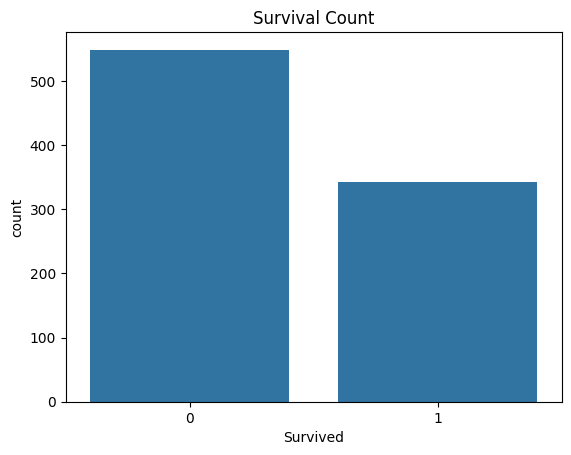

In [4]:
sns.countplot(x='Survived', data=df)
plt.title("Survival Count")
plt.show()

Age Distribution

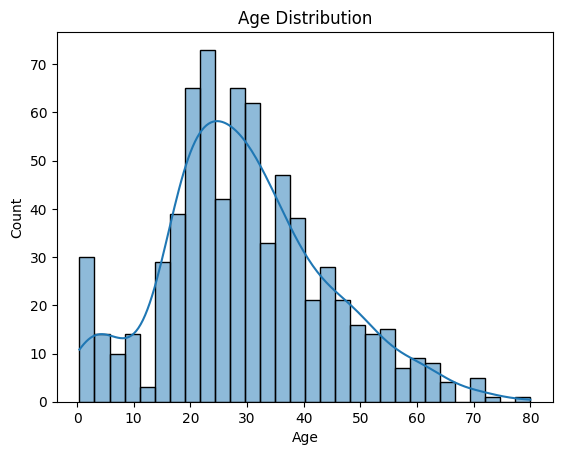

In [5]:
sns.histplot(df['Age'].dropna(), bins=30, kde=True)
plt.title("Age Distribution")
plt.show()

Survive By Gender

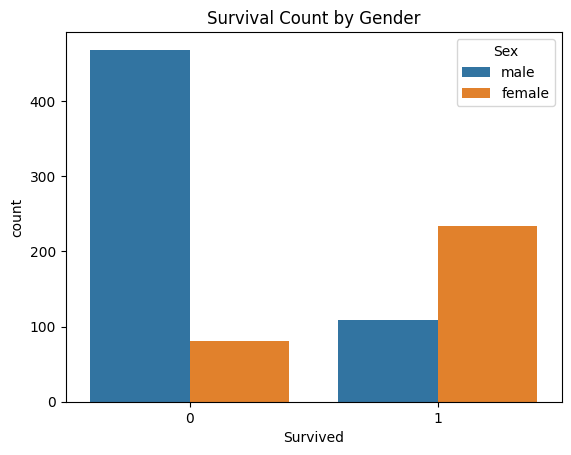

In [6]:
sns.countplot(x='Survived', hue='Sex', data=df)
plt.title("Survival Count by Gender")
plt.show()

Survive By PassengerClass

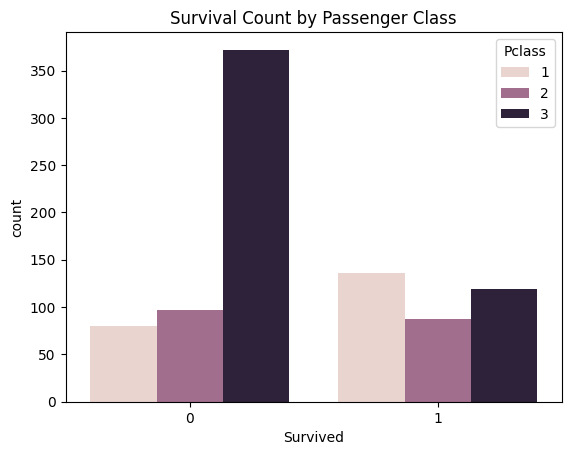

In [7]:
sns.countplot(x='Survived', hue='Pclass', data=df)
plt.title("Survival Count by Passenger Class")
plt.show()

Handling Missing Values

In [8]:
imputer_num = SimpleImputer(strategy='mean')
imputer_cat = SimpleImputer(strategy='most_frequent')

Encoding categorical variables

In [9]:
encoder = OneHotEncoder(handle_unknown='ignore')

Scaling numerical features

In [10]:
scaler = StandardScaler()

Select features

In [11]:
numeric_features = ['Age', 'Fare']
categorical_features = ['Sex', 'Pclass', 'Embarked']

Pipeline

In [12]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([("impute", imputer_num), ("scale", scaler)]), numeric_features),
        ('cat', Pipeline([("impute", imputer_cat), ("encode", encoder)]), categorical_features)
    ]
)

Split Data

In [13]:
y = df['Survived']
X = df.drop(columns=['Survived', 'Name', 'Ticket', 'Cabin'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Model Training

In [14]:
rf_model = RandomForestClassifier(random_state=42)
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='roc_auc')
pipeline = Pipeline([('preprocessor', preprocessor), ('model', grid_search)])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Pclass',
                                                   'Embarked'])])),
                ('model',
                 GridSearchCV(cv=5,
                              estimator=RandomForestClassifier(random_state=42),
                              param_grid={'max_depth': [None, 10, 20],
                                          'n_estimators': [50, 100, 200]},
                              scoring='roc_auc'))])

Predictions

In [15]:
y_train_pred = pipeline.predict_proba(X_train)[:, 1]
y_test_pred = pipeline.predict_proba(X_test)[:, 1]
print("AUC on Training Set:", roc_auc_score(y_train, y_train_pred))
print("AUC on Test Set:", roc_auc_score(y_test, y_test_pred))

AUC on Training Set: 0.9857889606023935
AUC on Test Set: 0.8925997425997426


Classification report

In [16]:
print("Classification Report:")
print(classification_report(y_test, pipeline.predict(X_test)))

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       105
           1       0.78      0.70      0.74        74

    accuracy                           0.79       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179

